# Forage de données - TP2
|          Nom          | Matricule  |   CIP    |
|:---------------------:|:----------:|:--------:|
|   Alexandre Theisse   | 23 488 180 | thea1804 |
| Louis-Vincent Capelli | 23 211 533 | capl1101 |
|      Tom Sartori      | 23 222 497 | sart0701 |

In [8]:
import pandas as pd


def load_joined_data(products='data/order_products__prior_specials.csv', orders='data/orders_distance_stores_softmax.csv'):
    products = pd.read_csv(products)
    orders = pd.read_csv(orders)
    orders.drop(['Unnamed: 0'], axis=1, inplace=True)
    joined = pd.merge(orders, products, on='order_id')
    joined.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
    cols = joined.columns.tolist()
    cols = cols[9:10] + cols[:4] + cols[5:9] + cols[10:12] + cols[-1:] + cols[4:5] + cols[12:-1]
    joined = joined[cols]
    return joined

In [22]:
joined_data = load_joined_data()
print('Columns: ' + ', '.join(joined_data.columns.tolist()))
print(f'Data has {joined_data.shape[0]} rows and {joined_data.shape[1]} columns')

Columns: id, user_id, store_id, distance, order_id, order_number, order_dow, order_hour_of_day, days_since_prior_order, product_id, add_to_cart_order, special, eval_set, reordered
Data has 1172312 rows and 14 columns


## 1. Analyse des données

### 1.(a) Réduction du nombre de données
Afin de réduire le temps de calcul, nous avons décidé de ne conserver qu'environ 5% des données initiales.

Il est important de conserver un échantillon représentatif des données initiales. Pour ce faire, plusieurs méthodes peuvent être utilisées :
- **Échantillonnage aléatoire des utilisateurs** : Chaque utilisateur a la même probabilité d'être sélectionné et avec lui toutes ses commandes et produits commandés. Cette méthode à l'avantage de conserver les relations entre les données. Elle permet d'éviter d'avoir un échantillon incohérent (ex : une commande qui est annoncée comme un renouvellement alors que l'utilisateur ne possède aucune autre commande dans l'échantillon).
- **Échantillonnage stratifié** : Chaque classe de l'attribut cible (ici *reordered*) représente la même proportion dans l'échantillon que dans les données initiales. Cette méthode permet de conserver la distribution de l'attribut cible.

Si nous parvenons à obtenir des résulats satisfaisants avec la première nous l'utiliserons, sinon nous utiliserons la seconde. Le but étant de conserver des distributions similaires à celles des données initiales pour chacun des attributs qui serviront à la prédiction.

On note également que l'attribut *reordered* est déséquilibré. En effet, la classe 0 ne représente que 10% des données. Il sera intéressant d'essayer de rééquilibrer les classes pour obtenir de meilleurs résultats.

#### Échantillonnage

In [81]:
from sklearn.model_selection import train_test_split

def get_random_sample(data, ratio=0.05):
    # Get a random sample of the users
    users = data['user_id'].unique()
    users_sample = pd.Series(users).sample(frac=ratio, random_state=1)
    
    # Get the data for the sampled users
    sampled_data = data[data['user_id'].isin(users_sample)]
    return sampled_data

def get_stratified_sample(data, ratio=0.05):
    x, y = data.drop(['reordered'], axis=1), data['reordered']
    _, x_test, _, y_test = train_test_split(x, y, test_size=ratio, stratify=y)
    return pd.concat([x_test, y_test], axis=1)

In [82]:
print('Random sample:')
random_sampled_data = get_random_sample(joined_data)
print(f'Data has {random_sampled_data.shape[0]} rows and {random_sampled_data.shape[1]} columns\n')

print('Stratified sample:')
stratified_sampled_data = get_stratified_sample(joined_data)
print(f'Data has {stratified_sampled_data.shape[0]} rows and {stratified_sampled_data.shape[1]} columns')

Random sample:
Data has 58251 rows and 14 columns

Stratified sample:
Data has 58616 rows and 14 columns


#### Visualisation des échantillons
Nous pouvons visualiser les distributions des attributs des échantillons pour vérifier que celles-ci sont similaires à celles des données initiales.

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt


def compare_distributions(original, random_sample, stratified_sample, columns):
    fig, axes = plt.subplots(len(columns)+1, 3, figsize=(15, 5 * len(columns)))
    for i, column in enumerate(columns):
        axes[i, 0] = sns.histplot(original[column], ax=axes[i, 0], kde=True)
        axes[i, 1] = sns.histplot(random_sample[column], ax=axes[i, 1], kde=True)
        axes[i, 2] = sns.histplot(stratified_sample[column], ax=axes[i, 2], kde=True)
        axes[i, 0].set_title(f'{column} - Original')
        axes[i, 1].set_title(f'{column} - Random sample')
        axes[i, 2].set_title(f'{column} - Stratified sample')
    fig.delaxes(axes[-1, 0]);fig.delaxes(axes[-1, 1]);fig.delaxes(axes[-1, 2])
    plt.tight_layout()
    plt.show()

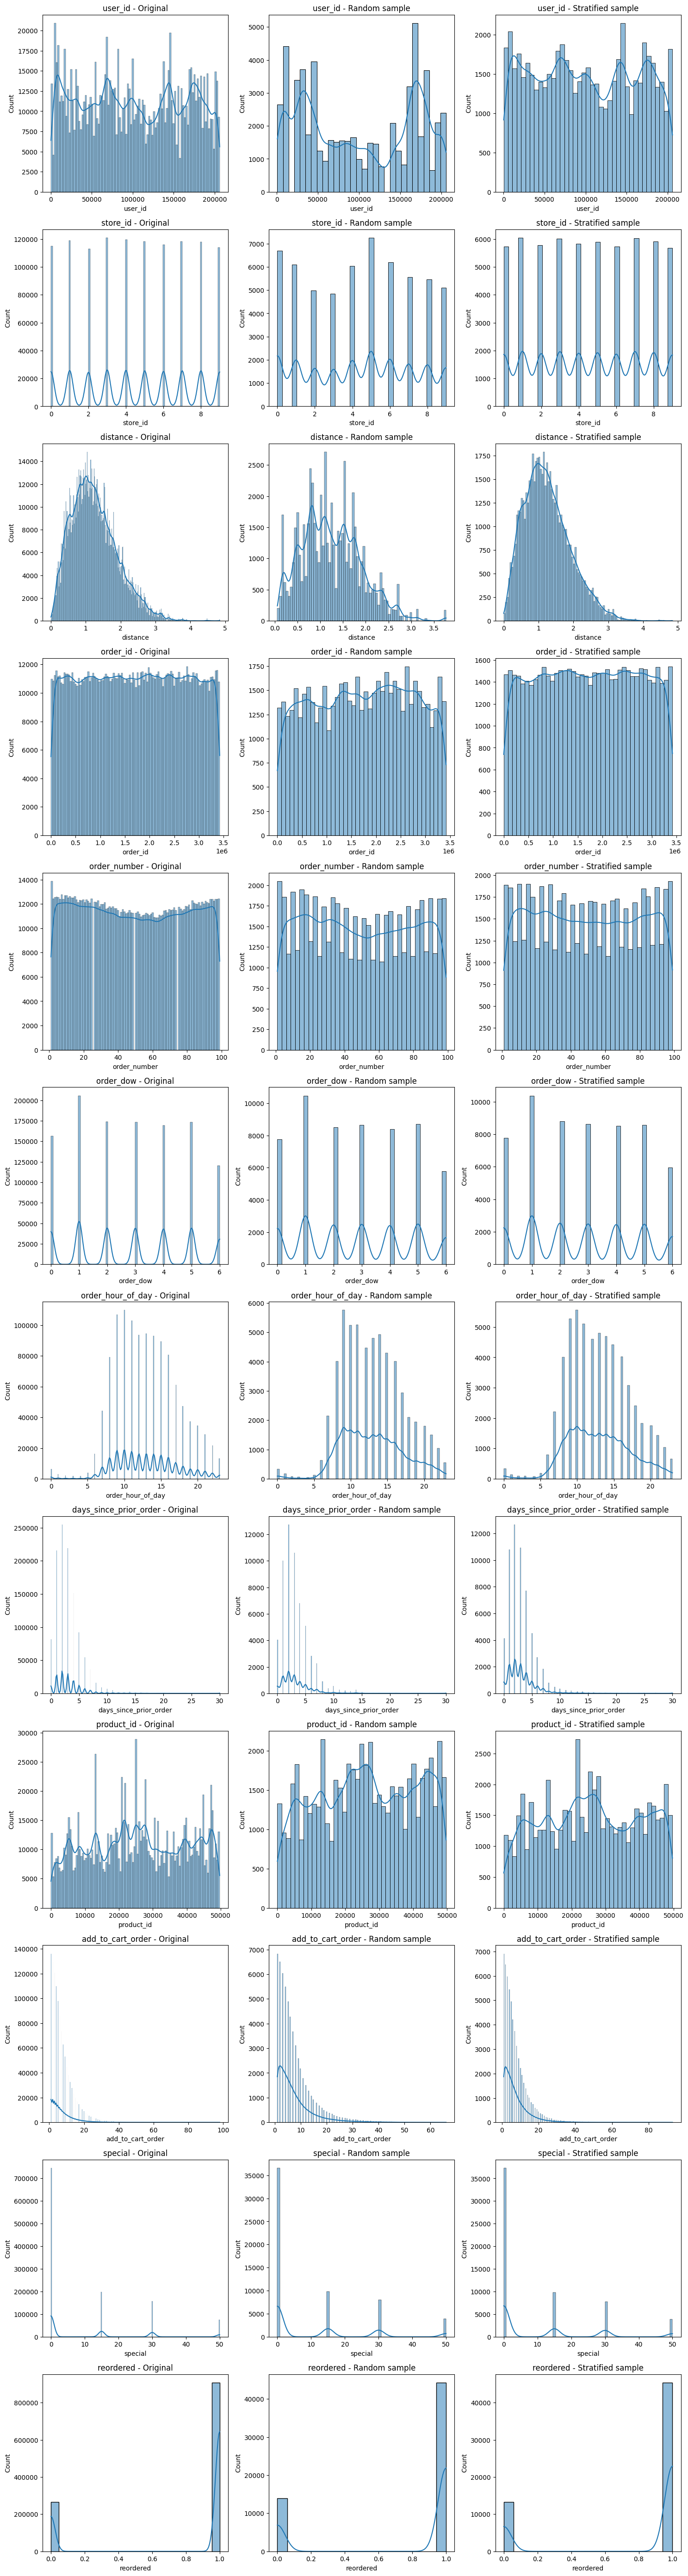

In [85]:
joined_data = load_joined_data()
random_sample = get_random_sample(joined_data)
stratified_sample = get_stratified_sample(joined_data)

compare_distributions(joined_data, random_sample, stratified_sample, ['user_id', 'store_id', 'distance', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'special', 'reordered'])

#### Statistiques descriptives
On peut également comparer les statistiques descriptives des échantillons avec celles des données initiales pour vérifier que les échantillons sont représentatifs des données initiales.

In [83]:
joined_data = load_joined_data()
random_sample = get_random_sample(joined_data)
stratified_sample = get_stratified_sample(joined_data)

for column in ['store_id', 'distance', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'special', 'reordered']:
    print(f'{column}:')
    print(' ' * 17 + '     Mean    |    Std   ')
    print(f'Original         : {joined_data[column].mean():^10.2f} | {joined_data[column].std():^10.2f}')
    print(f'Random sample    : {random_sample[column].mean():^10.2f} | {random_sample[column].std():^10.2f}')
    print(f'Stratified sample: {stratified_sample[column].mean():^10.2f} | {stratified_sample[column].std():^10.2f}')
    print('\n')

store_id:
                      Mean    |    Std   
Original         :    4.50    |    2.86   
Random sample    :    4.41    |    2.85   
Stratified sample:    4.50    |    2.86   


distance:
                      Mean    |    Std   
Original         :    1.25    |    0.66   
Random sample    :    1.25    |    0.65   
Stratified sample:    1.25    |    0.66   


order_id:
                      Mean    |    Std   
Original         : 1710805.86 | 986504.94 
Random sample    : 1733979.12 | 974794.87 
Stratified sample: 1709744.73 | 986813.78 


order_number:
                      Mean    |    Std   
Original         :   49.51    |   29.06   
Random sample    :   49.24    |   29.14   
Stratified sample:   49.65    |   29.02   


order_dow:
                      Mean    |    Std   
Original         :    2.85    |    1.92   
Random sample    :    2.84    |    1.92   
Stratified sample:    2.86    |    1.92   


order_hour_of_day:
                      Mean    |    Std   
Original         : 

On constate que les deux méthodes de réduction des données donnent des résultats très similaires, si ce n'est exactement identiques.

Les moyennes et les écarts-types des attributs numériques sont très proches de ceux des données initiales. 

Les distributions présentent exactement les mêmes formes, sauf pour l'attribut *distance* par exemple, où l'échantillonage par utilisateur donne une distribution moins lisse, plus fidèle à la distribution initiale puisque chaque utilisateur sélectionné a une distance fixe à chacun des magasins et qu'il est représenté dans l'échantillon par tous ses produits commandés. Même chose pour *user_id* évidemment.